In [1]:
save_figures = True
save_tables = True

In [2]:
from shapely.geometry import Point, Polygon
import geoplot
import geoplot.crs as gcrs


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import geopandas as gpd

In [3]:
gdf = gpd.read_file('../datasets/kenya_ipc.geojson')
df_loc = pd.concat([gdf['area'], gdf.centroid.x, gdf.centroid.y], axis=1)
df_loc.columns = ['area', 'long', 'lat']
gdf.set_index('area', inplace=True)

C:\Users\casch\AppData\Local\Temp\ipykernel_14180\983415286.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_loc = pd.concat([gdf['area'], gdf.centroid.x, gdf.centroid.y], axis=1)
C:\Users\casch\AppData\Local\Temp\ipykernel_14180\983415286.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_loc = pd.concat([gdf['area'], gdf.centroid.x, gdf.centroid.y], axis=1)


In [4]:
df_ke = pd.read_csv('../datasets/kenya_ipc.csv', sep=';', header=None, usecols=[0, 3, 4, 5])
df_ke.columns = ['area', 'date', '3_plus', '3_plus_proj']
df_ke['date'] = pd.to_datetime(df_ke['date'])
df_ke = df_ke.merge(df_loc, left_on=['area'], right_on=['area'])
df_ke['3_plus'] = df_ke['3_plus'].str.rstrip('%').astype('int')
df_ke['3_plus_proj'] = df_ke['3_plus_proj'].str.rstrip('%').astype('int')
df_ipc = df_ke

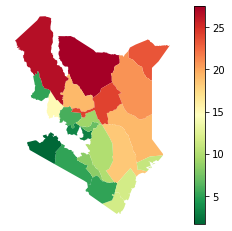

In [5]:
fig, ax = plt.subplots()
gdf.merge(df_ipc.groupby('area')['3_plus'].mean(), left_on='area', right_index=True).plot('3_plus', cmap='RdYlGn_r', legend=True, ax=ax)
ax.axis('off')
fig.savefig('../figures/kenya_ipc_dist.pdf', format='pdf')

In [6]:
df_tweets = pd.read_csv('../datasets/twitter/kenya_tweets.csv', parse_dates=['date'])
df_lab = pd.read_csv('../datasets/twitter/tweet_category_labels_kenya.csv')
df_tweets = pd.concat([df_tweets, df_lab], axis=1)

In [7]:
df = df_tweets[['date', 'label', 'score', 'long', 'lat', ]].copy()
df['is_news'] = df['label'] == 'news_&_social_concern'
df['is_personal'] = df['label'] == 'diaries_&_daily_life'
df['date'] = df['date'].dt.tz_localize(None)

In [8]:
areas = []
coords = df[['long', 'lat']].to_numpy()
for coord in coords:
    contains = gdf.contains(Point(coord[0], coord[1]))
    if contains.sum() > 0:
        area = contains.idxmax()
        areas.append(area)
    else:
        areas.append(None)
df['area'] = pd.Series(areas)
df = df.dropna(subset='area')

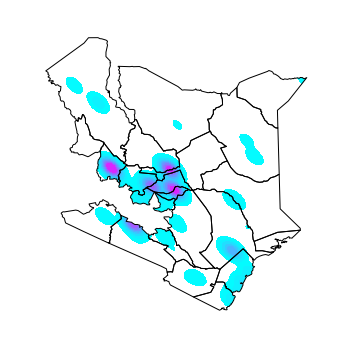

In [9]:
ax = geoplot.kdeplot(gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.long, df.lat)), projection=gcrs.AlbersEqualArea(), cmap='cool', shade=True, clip=gdf, alpha=1)
geoplot.polyplot(gdf, ax=ax, zorder=1000, projection=gcrs.AlbersEqualArea());

if save_figures:
   plt.savefig('../figures/tweets_location_kenya.pdf', format='pdf')

In [10]:
def construct_data(lag, size, date_range=[], dropoff_pow=1, epsilon=0.1, no_drop=False):
    data = []
    lag = pd.DateOffset(months=lag)
    size = pd.DateOffset(months=size)
    
    if date_range:
        date_mask = (df_ipc['date'] >= pd.to_datetime(date_range[0])) & (df_ipc['date'] <= pd.to_datetime(date_range[1]))
        df_iterator = df_ipc[date_mask].iterrows()
    else:
        df_iterator = df_ipc.iterrows()
        
    for idx, row in df_iterator:
        polygon = gdf.loc[row['area']].geometry
        mask = (df['date'] <= row['date'] - lag) &\
            (df['date'] >= row['date'] - lag - size)
        ipc_mask = (df_ipc['area'] == row['area']) & (df_ipc['date'] <= row['date'] - lag) & (df_ipc['date'] >= row['date'] - lag - size)
        temp_df = df[mask]
        if len(temp_df) < 1000:
            continue
        temp_df = temp_df[temp_df['area'] == str(row['area'])]
        if(len(temp_df) < 1):
            continue
        data.append([
                np.average(temp_df['is_news'] * temp_df['score']),
                np.average(temp_df['is_personal'] * temp_df['score']),
                df_ipc[ipc_mask]['3_plus_proj'].mean()/100,
                df_ipc[ipc_mask]['3_plus'].mean()/100,
                row['3_plus']/100,
                row['area'],
                row['date']])
        
    data = pd.DataFrame(data)
    data.columns = ['is_news', 'is_personal', '3_plus_proj', '3_plus_past', '3_plus', 'dis', 'date']
    if no_drop:
        return data
    return data.dropna()

In [11]:
data = construct_data(3, 4, dropoff_pow=0, epsilon=0.001)
data = data.set_index(['dis', 'date'])
X, y = data.loc[:, ['is_news', '3_plus_proj']], data.iloc[:, -1]
X['const'] = 1
reg = sm.OLS(y, X).fit(cov_type='hc0')
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 3_plus   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     16.07
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           1.32e-06
Time:                        14:08:36   Log-Likelihood:                 105.85
No. Observations:                  84   AIC:                            -205.7
Df Residuals:                      81   BIC:                            -198.4
Df Model:                           2                                         
Covariance Type:                  hc0                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
is_news         0.1459      0.049      2.971      0.003       0.050       0.242
3_plus_proj     0.3697      0.080      4.632      0.000       0.213       0.526
const           0.0053      0.016      0.330      0.741      -0.026       0.037
==============================================================================
Omnibus:                       30.631   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.794
Skew:                           1.366   Prob(JB):                     1.04e-13
Kurtosis:                       6.102   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

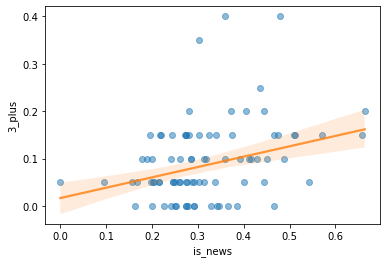

In [12]:
fig, ax = plt.subplots()
sns.regplot(data=data, x='is_news', y='3_plus', scatter_kws={'alpha': 0.5},  line_kws={'color': 'tab:orange', 'alpha': 0.8}, robust=True, ax=ax)

fig.savefig('kenya_reg_scatter.pdf', format='pdf')